In [26]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import datetime as datetime
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2017_train.csv", parse_dates = ['time:timestamp'])
df_val = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2017_val.csv", parse_dates = ['time:timestamp'])
df_test = pd.read_csv("/content/drive/MyDrive/DBL Process Mining/Data/Split/bpi2017_test.csv", parse_dates = ['time:timestamp'])

# The default name indicating the case ID is case:concept:name
# concept:name is the event
# time:timestamp is the corresponding timestamp
# Load the datasets, sort them on case and consequently timestamp, then reset the index
df_train = df_train.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()
df_val = df_val.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()
df_test = df_test.sort_values(by = ['case:concept:name', 'time:timestamp']).reset_index()

# Remove obsolete columns
df_train = df_train.drop(['index', 'Unnamed: 0'], axis = 1)
df_val = df_val.drop(['index', 'Unnamed: 0'], axis = 1)
df_test = df_test.drop(['index', 'Unnamed: 0'], axis = 1)

# 1. Calculate the time difference

In [5]:
# Cumulative sum function to be used later
def CumSum(lists):
    # Returns the cumulative sum of a list
    length = len(lists)
    cu_list = [sum(lists[0: x: 1]) for x in range(0, length + 1)]
    return cu_list[1: ]

In [6]:
def time_difference(df):
    # Calculate time difference between each row
    df['time_diff'] = df['time:timestamp'].diff().dt.total_seconds()
    # Set the time difference of the 1st row to 0 as it's currently NaN
    df.at[0, 'time_diff'] = 0
    # Count number of steps per process
    length_per_case_List = df.groupby(['case:concept:name'])['time_diff'].count().tolist()

    # Using the cumulative sum we get all the positions that are a first step in a process
    # And then the time difference can be set to 0
    position_lst = CumSum(length_per_case_List)
    for i in tqdm(position_lst):
        df.at[i, 'time_diff'] = 0
    # For Loop mysteriously creates an empty row at the end of the df, gotta delete it
    df = df.iloc[: -1]

    # Unzip the position list to get the number of each steps of each process, make that into a list
    step_in_process = []
    for x in tqdm(length_per_case_List):
        for y in range(x):
            step_in_process.append(y + 1)
    # Assign position number to each row/process
    df['position'] = step_in_process
    return df

In [7]:
# Apply the above changes to all dataframes
# The warnings are obsolete, it's because it uses .at which is considerably faster than .loc
df_train = time_difference(df_train)
df_val = time_difference(df_val)
df_test = time_difference(df_test)

100%|██████████| 16308/16308 [00:00<00:00, 234766.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 751/751 [00:00<00:00, 177170.95it/s]


# 2. Baseline Time Prediction (Only on Training Dataset)

In [8]:
# Get the list of position number
step_in_process_train = df_train['position'].tolist()
# Calculate mean time difference grouped by position based on the number of cases
mean_time_lst = df_train.groupby('position')['time_diff'].mean().tolist()

# Create the predicted time column per entry using the mean time difference
pred_time_lst_train = [mean_time_lst[j - 1] for j in step_in_process_train]
df_train['baseline_predicted_time'] = pred_time_lst_train
df_train

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,time_diff,position,baseline_predicted_time
0,Created,User_1,A_Create Application,Application,Application_1000086665,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1,0.000000
1,statechange,User_1,A_Submitted,Application,ApplState_161925113,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061,2,0.111101
2,Created,User_1,W_Handle leads,Workflow,Workitem_747707399,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,3,0.246668
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1030261128,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.323,4,2458.898740
4,Created,User_1,W_Complete application,Workflow,Workitem_1127124826,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007,5,103.639233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621126,Obtained,User_68,W_Validate application,Workflow,Workitem_715332932,resume,2016-04-26 09:22:34.654000+00:00,Home improvement,New credit,Application_610205010,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6159.402,67,25132.608475
621127,statechange,User_68,O_Accepted,Offer,OfferState_287854721,complete,2016-04-26 09:23:27.987000+00:00,Home improvement,New credit,Application_610205010,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_772484790,53.333,68,23565.914279
621128,statechange,User_68,A_Pending,Application,ApplState_1161629338,complete,2016-04-26 09:23:28.009000+00:00,Home improvement,New credit,Application_610205010,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022,69,29047.012018
621129,Deleted,User_68,W_Validate application,Workflow,Workitem_1093600680,complete,2016-04-26 09:23:28.012000+00:00,Home improvement,New credit,Application_610205010,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003,70,28068.582187


In [73]:
# Add a column with the squared difference between the actual and predicted time difference
df_train['error_squared'] = (df_train['time_diff']-df_train['baseline_predicted_time'])**2
# Calculate the Mean Squared Error as the average of all squared differences.
mse_train = sum(df_train['error_squared'])/len(df_train['error_squared'])
mse_train

49528289154.455925

# 3. Apply Above Calculated Mean Time to Validation and Test Set

In [9]:
def apply_prediction(df):
    # Get the list of position number
    step_in_process = df['position'].tolist()

    # Create the predicted time column per entry using the mean time difference
    # If some position numbers are not shown in the training dataset, its predicted time will be 0
    pred_time_lst = []
    for j in step_in_process:
        if j <= len(mean_time_lst):
            pred_time_lst.append(mean_time_lst[j - 1])
        else:
            pred_time_lst.append(0)
    df['baseline_predicted_time'] = pred_time_lst
    return df

In [10]:
# Apply the above changes to all dataframes
df_val = apply_prediction(df_val)
df_test = apply_prediction(df_test)
df_val

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,time_diff,position,baseline_predicted_time
0,Created,User_1,A_Create Application,Application,Application_100034150,complete,2016-02-26 08:17:08.702000+00:00,Existing loan takeover,New credit,Application_100034150,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1,0.000000
1,statechange,User_1,A_Submitted,Application,ApplState_1876536887,complete,2016-02-26 08:17:08.781000+00:00,Existing loan takeover,New credit,Application_100034150,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079,2,0.111101
2,Created,User_1,W_Handle leads,Workflow,Workitem_1857743533,schedule,2016-02-26 08:17:09.360000+00:00,Existing loan takeover,New credit,Application_100034150,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579,3,0.246668
3,Obtained,User_5,W_Handle leads,Workflow,Workitem_1381927478,start,2016-02-26 09:18:19.304000+00:00,Existing loan takeover,New credit,Application_100034150,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3669.944,4,2458.898740
4,Deleted,User_5,W_Handle leads,Workflow,Workitem_1723165043,complete,2016-02-26 09:18:43.550000+00:00,Existing loan takeover,New credit,Application_100034150,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.246,5,103.639233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154996,Obtained,User_30,W_Validate application,Workflow,Workitem_1318522010,resume,2016-03-07 13:17:01.830000+00:00,Car,New credit,Application_610156903,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.341,56,32252.319283
154997,Released,User_30,W_Validate application,Workflow,Workitem_2034548280,suspend,2016-03-07 13:17:16.104000+00:00,Car,New credit,Application_610156903,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.274,57,29674.466326
154998,statechange,User_119,O_Accepted,Offer,OfferState_1905445856,complete,2016-03-07 13:22:38.720000+00:00,Car,New credit,Application_610156903,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_2020782644,322.616,58,34582.478479
154999,statechange,User_119,A_Pending,Application,ApplState_316927626,complete,2016-03-07 13:22:38.724000+00:00,Car,New credit,Application_610156903,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004,59,32078.071226


In [11]:
df_test

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,time_diff,position,baseline_predicted_time
0,Created,User_1,A_Create Application,Application,Application_610717758,complete,2016-11-19 23:12:05.325000+00:00,Car,New credit,Application_610717758,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1,0.000000
1,statechange,User_1,A_Submitted,Application,ApplState_1960150929,complete,2016-11-19 23:12:06.411000+00:00,Car,New credit,Application_610717758,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.086,2,0.111101
2,Created,User_1,W_Handle leads,Workflow,Workitem_684900503,schedule,2016-11-19 23:12:06.690000+00:00,Car,New credit,Application_610717758,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.279,3,0.246668
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_954760450,withdraw,2016-11-19 23:12:47.428000+00:00,Car,New credit,Application_610717758,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.738,4,2458.898740
4,Created,User_1,W_Complete application,Workflow,Workitem_1752703538,schedule,2016-11-19 23:12:47.435000+00:00,Car,New credit,Application_610717758,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007,5,103.639233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28701,Deleted,User_1,W_Call after offers,Workflow,Workitem_1894495253,ate_abort,2016-12-20 06:32:24.316000+00:00,Existing loan takeover,New credit,Application_999632431,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331831.284,19,179930.167417
28702,Created,User_1,W_Call after offers,Workflow,Workitem_1671270331,schedule,2016-12-20 06:32:24.326000+00:00,Existing loan takeover,New credit,Application_999632431,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010,20,140876.609935
28703,statechange,User_1,A_Cancelled,Application,ApplState_318084843,complete,2017-01-16 07:00:30.429000+00:00,Existing loan takeover,New credit,Application_999632431,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2334486.103,21,113138.949017
28704,statechange,User_1,O_Cancelled,Offer,OfferState_560115325,complete,2017-01-16 07:00:30.449000+00:00,Existing loan takeover,New credit,Application_999632431,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_872978767,0.020,22,142972.096573


In [74]:
# Add a column with the squared difference between the actual and predicted time difference 
df_test['error_squared'] = (df_test['time_diff']-df_test['baseline_predicted_time'])**2
# Calculate the Mean Squared Error as the average of all squared differences. 
mse_test = sum(df_test['error_squared'])/len(df_test['error_squared'])
mse_test

53060529114.41289

In [76]:
# Add a column with the squared difference between the actual and predicted time difference 
df_val['error_squared'] = (df_val['time_diff']-df_val['baseline_predicted_time'])**2
# Calculate the Mean Squared Error as the average of all squared differences.
mse_val = sum(df_val['error_squared'])/len(df_val['error_squared'])
mse_val

50438186785.065865

In [78]:
mse_test/mse_train

1.0713176251443197

In [79]:
mse_val/mse_train

1.018371271169339

In [75]:
position_lst = list(range(1, len(mean_time_lst) + 1))
df_prediction = pd.DataFrame(position_lst)
df_prediction['predicted_time'] = mean_time_lst
df_prediction = df_prediction.rename(columns = {0: 'position'})
df_prediction

,position,predicted_time
0,1,0.000000
1,2,0.111101
2,3,0.246668
3,4,2458.898740
4,5,103.639233
...,...,...
175,176,585012.400000
176,177,0.003000
177,178,0.003000
178,179,0.012000


Text(0.5, 1.0, 'Baseline Predicted Time')

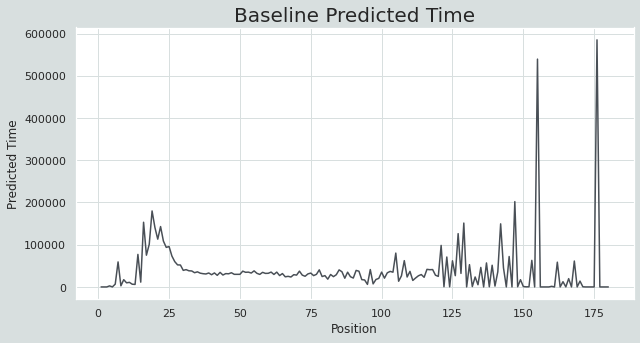

In [71]:
# figure size
sns.set(rc={'figure.figsize':(10,5)})
# color (palette)
colors = ["#494f56", "#d8dfdf"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.set(rc={'axes.facecolor':'#ffffff', 'figure.facecolor':'#d8dfdf', 
            "grid.color":'#d8dfdf'})

ax = sns.lineplot(data = df_prediction, x = "position", y = "predicted_time", color='#494f56');
ax.set_xlabel('Position')
ax.set_ylabel('Predicted Time')
ax.set_title('Baseline Predicted Time', size = 20)

In [ ]:
df_prediction.to_csv('baseline_time.csv')